Queen's Campus Campus Pathfinding
Reinforcment Learning agent who uses Q-Learning to find the shortest path between two points on Campus

CISC 474
names and SN's (insert before handing in - Not while on Github though)
- 
- 
- 
-

Reference Materials:

[Overpass API/Overpass QL](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL): API and Query Language for accessing Open Street Maps data.

[Overpass Turbo](https://overpass-turbo.eu/): Website to help build and visualize Overpass API calls.

[OverPy](https://python-overpy.readthedocs.io/en/latest/api.html): Python Wrapper for Overpass


#Graph Implementation:
- https://github.com/Tofull/networkx-osm/blob/master/OSMParser.py
- https://networkx.org/documentation/networkx-2.4/reference/classes/generated/networkx.Graph.neighbors.html





## Data Import and Preprocessing

In [137]:
import copy
import urllib.request
import xml.sax
from math import radians, cos, sin, asin, sqrt
from pathlib import Path

import networkx
!pip install networkx


def haversine_distance(lon1, lat1, lon2, lat2, unit_m=True):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    default unit : km
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of the Earth in kilometers. Use 3956 for miles
    if unit_m:
        r *= 1000
    return c * r


def download_osm(left=-73.4244, bottom=45.4302, right=-73.4010, top=45.4466, proxy=False, cache=False, cacheTempDir="/tmp/tmpOSM/", verbose=True):
    """ Return a filehandle to the downloaded data from osm api."""
    if cache:
        # cached tile filename
        cachedTileFilename = "osm_map_{:.8f}_{:.8f}_{:.8f}_{:.8f}.map".format(left, bottom, right, top)

        if verbose:
            print("Cached tile filename :", cachedTileFilename)

        cacheTempDir = Path(cacheTempDir)
        cacheTempDir.mkdir(parents=True, exist_ok=True)  # Create cache path if not exists

        osmFile = Path(cacheTempDir / cachedTileFilename).resolve()  # Replace the relative cache folder path to absolute path

        if osmFile.is_file():
            # download from the cache folder
            if verbose:
                print("Tile loaded from the cache folder.")

            with open(osmFile, mode='r') as f:
                content = f.read()
            return content

    if proxy:
        # configure the urllib request with the proxy
        proxy_handler = urllib.request.ProxyHandler({'https': 'https://' + proxyHost + ":" + proxyPort, 'http': 'http://' + proxyHost + ":" + proxyPort})
        opener = urllib.request.build_opener(proxy_handler)
        urllib.request.install_opener(opener)

    request = "http://api.openstreetmap.org/api/0.6/map?bbox=%f,%f,%f,%f" % (left, bottom, right, top)

    if verbose:
        print("Download the tile from osm web api ... in progress")
        print("Request :", request)

    fp = urllib.request.urlopen(request)
    content = fp.read().decode('utf-8')

    if verbose:
        print("OSM Tile downloaded")

    if cache:
        if verbose:
            print("Write osm tile in the cache")

        with open(osmFile, 'w') as f:
            f.write(content)

        if osmFile.is_file():
            if verbose:
                print("OSM tile written in the cache")

    return content


def read_osm(osm_xml_data, is_xml_string=True, only_roads=True):
    """Read graph in OSM format from file specified by name or by stream object.
    Parameters
    ----------
    filename_or_stream : filename or stream object
    Returns
    -------
    G : Graph
    Examples
    --------
    >>> G=nx.read_osm(nx.download_osm(-122.33,47.60,-122.31,47.61))
    >>> import matplotlib.pyplot as plt
    >>> plt.plot([G.node[n]['lat']for n in G], [G.node[n]['lon'] for n in G], 'o', color='k')
    >>> plt.show()
    """
    osm = OSM(osm_xml_data, is_xml_string=is_xml_string)
    G = networkx.DiGraph()

    ## Add ways
    for w in osm.ways.values():
        if only_roads and 'highway' not in w.tags:
            continue

        if ('oneway' in w.tags):
            if (w.tags['oneway'] == 'yes'):
                # ONLY ONE DIRECTION
                networkx.add_path(G, w.nds, id=w.id)
            else:
                # BOTH DIRECTION
                networkx.add_path(G, w.nds, id=w.id)
                networkx.add_path(G, w.nds[::-1], id=w.id)
        else:
            # BOTH DIRECTION
            networkx.add_path(G, w.nds, id=w.id)
            networkx.add_path(G, w.nds[::-1], id=w.id)

    # Complete the used nodes' information
    coordinates_map = {}
    for n_id in G.nodes():
        n = osm.nodes[n_id]
        G.nodes[n_id]['lat'] = n.lat
        G.nodes[n_id]['lon'] = n.lon
        G.nodes[n_id]['id'] = n.id
        coordinates_map[n_id] = (n.lon, n.lat)

    # Estimate the length of each way
    for u, v, d in G.edges(data=True):
        distance = haversine_distance(G.nodes[u]['lon'], G.nodes[u]['lat'], G.nodes[v]['lon'], G.nodes[v]['lat'], unit_m=True)  # Give a realistic distance estimation (neither EPSG nor projection nor reference system are specified)

        G.add_weighted_edges_from([(u, v, distance)], weight='havlen')

    G = networkx.relabel_nodes(G, coordinates_map)
    return G


class Node(object):
    def __init__(self, id, lon, lat):
        self.id = id
        self.lon = lon
        self.lat = lat
        self.tags = {}

    def __str__(self):
        return "Node (id : %s) lon : %s, lat : %s "%(self.id, self.lon, self.lat)


class Way(object):
    def __init__(self, id, osm):
        self.osm = osm
        self.id = id
        self.nds = []
        self.tags = {}

    def split(self, dividers):
        # slice the node-array using this nifty recursive function
        def slice_array(ar, dividers):
            for i in range(1,len(ar)-1):
                if dividers[ar[i]]>1:
                    left = ar[:i+1]
                    right = ar[i:]

                    rightsliced = slice_array(right, dividers)

                    return [left]+rightsliced
            return [ar]

        slices = slice_array(self.nds, dividers)

        # create a way object for each node-array slice
        ret = []
        i = 0
        for slice in slices:
            littleway = copy.copy(self)
            littleway.id += "-%d" % i
            littleway.nds = slice
            ret.append(littleway)
            i += 1

        return ret


class OSM(object):
    def __init__(self, osm_xml_data, is_xml_string=True):
        """ File can be either a filename or stream/file object.
        set `is_xml_string=False` if osm_xml_data is a filename or a file stream.
        """
        nodes = {}
        ways = {}

        superself = self

        class OSMHandler(xml.sax.ContentHandler):
            @classmethod
            def setDocumentLocator(self, loc):
                pass

            @classmethod
            def startDocument(self):
                pass

            @classmethod
            def endDocument(self):
                pass

            @classmethod
            def startElement(self, name, attrs):
                if name == 'node':
                    self.currElem = Node(attrs['id'], float(attrs['lon']), float(attrs['lat']))
                elif name == 'way':
                    self.currElem = Way(attrs['id'], superself)
                elif name == 'tag':
                    self.currElem.tags[attrs['k']] = attrs['v']
                elif name == 'nd':
                    self.currElem.nds.append(attrs['ref'])

            @classmethod
            def endElement(self, name):
                if name == 'node':
                    nodes[self.currElem.id] = self.currElem
                elif name == 'way':
                    ways[self.currElem.id] = self.currElem

            @classmethod
            def characters(self, chars):
                pass

        if is_xml_string:
            xml.sax.parseString(osm_xml_data, OSMHandler)
        else:
            with open(osm_xml_data, mode='r') as f:
                xml.sax.parse(f, OSMHandler)

        self.nodes = nodes
        self.ways = ways

        # count times each node is used
        node_histogram = dict.fromkeys(self.nodes.keys(), 0)
        for way in self.ways.values():
            if len(way.nds) < 2:  # if a way has only one node, delete it out of the osm collection
                del self.ways[way.id]
            else:
                for node in way.nds:
                    node_histogram[node] += 1

        # use that histogram to split all ways, replacing the member set of ways
        new_ways = {}
        for id, way in self.ways.items():
            split_ways = way.split(node_histogram)
            for split_way in split_ways:
                new_ways[split_way.id] = split_way
        self.ways = new_ways


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Create and parse Graph from osm data

Download the tile from osm web api ... in progress
Request : http://api.openstreetmap.org/api/0.6/map?bbox=-76.501706,44.222450,-76.490355,44.229823
OSM Tile downloaded
[(-76.4905204, 44.2249349), (-76.4906166, 44.2249251), (-76.4908169, 44.2249044), (-76.4910503, 44.2248791), (-76.4916043, 44.2247953), (-76.4920893, 44.2247281), (-76.4925185, 44.2246686), (-76.4933756, 44.2245498), (-76.4937009, 44.2245047), (-76.4941718, 44.2244394), (-76.4945764, 44.2243834), (-76.4949564, 44.2243307), (-76.4950209, 44.2243218), (-76.4981811, 44.2226623), (-76.4981973, 44.2227323), (-76.4982021, 44.2227555), (-76.4982693, 44.2232467), (-76.4983231, 44.2237133), (-76.4983266, 44.2237433), (-76.4983337, 44.2238048), (-76.4828884, 44.226855), (-76.4829824, 44.2268996), (-76.4830129, 44.226914), (-76.4831565, 44.2269821), (-76.4835019, 44.2271458), (-76.4838035, 44.2272888), (-76.4838653, 44.2273181), (-76.4839521, 44.2273593), (-76.4840286, 44.2273956), (-76.4840597, 44.2274103), (-76.4851312, 44.22791

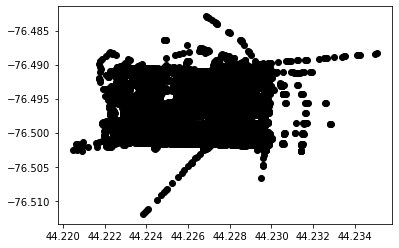

<class 'networkx.classes.graph.Graph'>


In [138]:
d = download_osm(left=-76.5017059541, bottom=44.2224495448, right=-76.4903552918, top=44.2298231916)
G = read_osm(d,only_roads=False)

# G is undirected

# G is now directed
G = G.to_undirected()
print(G.nodes)

plt.plot([G.nodes[n]['lat']for n in G], [G.nodes[n]['lon'] for n in G], 'o', color='k')
plt.show()

print(type(G))

Nodes are (lat,lon) tuples of coordinates

In [139]:
NV = G.nodes()
i = 0
for n in NV:
  i+=1
  if i < 4:
    print(n)
    print(type(n))
    #print()

#print(np.random.choice(NV[0]))

(-76.4905204, 44.2249349)
<class 'tuple'>
(-76.4906166, 44.2249251)
<class 'tuple'>
(-76.4908169, 44.2249044)
<class 'tuple'>


In [140]:
#G.adj(nv[0])

## Q-Learning

In [141]:
class Q_learning:

  def __init__(self, world: CWorld, alpha, gamma, e, max_eps=500, max_steps=500): 
    self.q = {}
    self.alpha = alpha #(0,1)
    self.gamma = gamma 
    self.e = e # e > 0
    self.max_eps= max_eps
    self.world = world
    self.max_steps = max_steps

    #Q-Table set up
    #States are nodes,
    #Actions are edges between these nodes
    for node in world.data.nodes():
        self.q[node] = {}
        
        if node != self.world._terminal:
        
          for adjNode in self.world.get_adjacent(node): 
            self.q[node][adjNode] = 10

        else:
          #Terminal
          for adjNode in self.world.get_adjacent(node):
              self.q[node][nextNode] = 0

  def get_next_state(self,node: tuple,epsilon=True):
      eps = self.e
      if not epsilon:
        eps = 0

      #print(node1)
      #node = (node1[0],node1[1])
      #print(node)
      mx_nxt_reward = -9999
      action: tuple

      rc = np.random.choice(['exploit','explore'], p=[1-eps, eps])

      if rc == 'exploit':
          #parse
          for s_prime in self.q[node]:

            nxt_reward = self.Q[node][s_prime]
  
            if nxt_reward >= mx_nxt_reward:
                action = s_prime
                mx_nxt_reward = nxt_reward

      elif rc == "explore":
          action = np.random.choice(list(self.q[node]))
        
      return action
  
  def train(self):
    for i in range(0, self.max_eps):
        s = self.world._start
        cur_steps = 0
        
        while s != self.world._terminal and cur_steps < self.max_steps:
            cur_steps = cur_steps+1

            #Choose a from S using policy derived from q
            a = self.get_next_state(s)

            # Take action A, observe S', R
            s_prime = a
            r = (self.world.get_reward(s,s_prime))

            qsa = self.q[s][a]
            maxa = self.get_next_state(s,e=False)#greedy
            self.q[s][a] = qsa + self.alpha*(r + self.gamma * (self.q[s_prime][maxa]) - qsa )

            s = s_prime

  def optimal_policy(self):#start=self._start,end=self._terminal):
    # Return list of optimal policy 
    # if s is an element of type (lat,lon)
    #return:
    #[start,s2,s3,s4......,s_n-1,terminal
    nodeList = []
    s = self.world._start
    e = self.world._terminal
    nodeList.append(s)

    while s != e:
      s_plus1 = self.get_next_state(s,epsilon=False) #greedy
      nodeList.append(s_plus1)
      s = s_plus1
    return nodeList


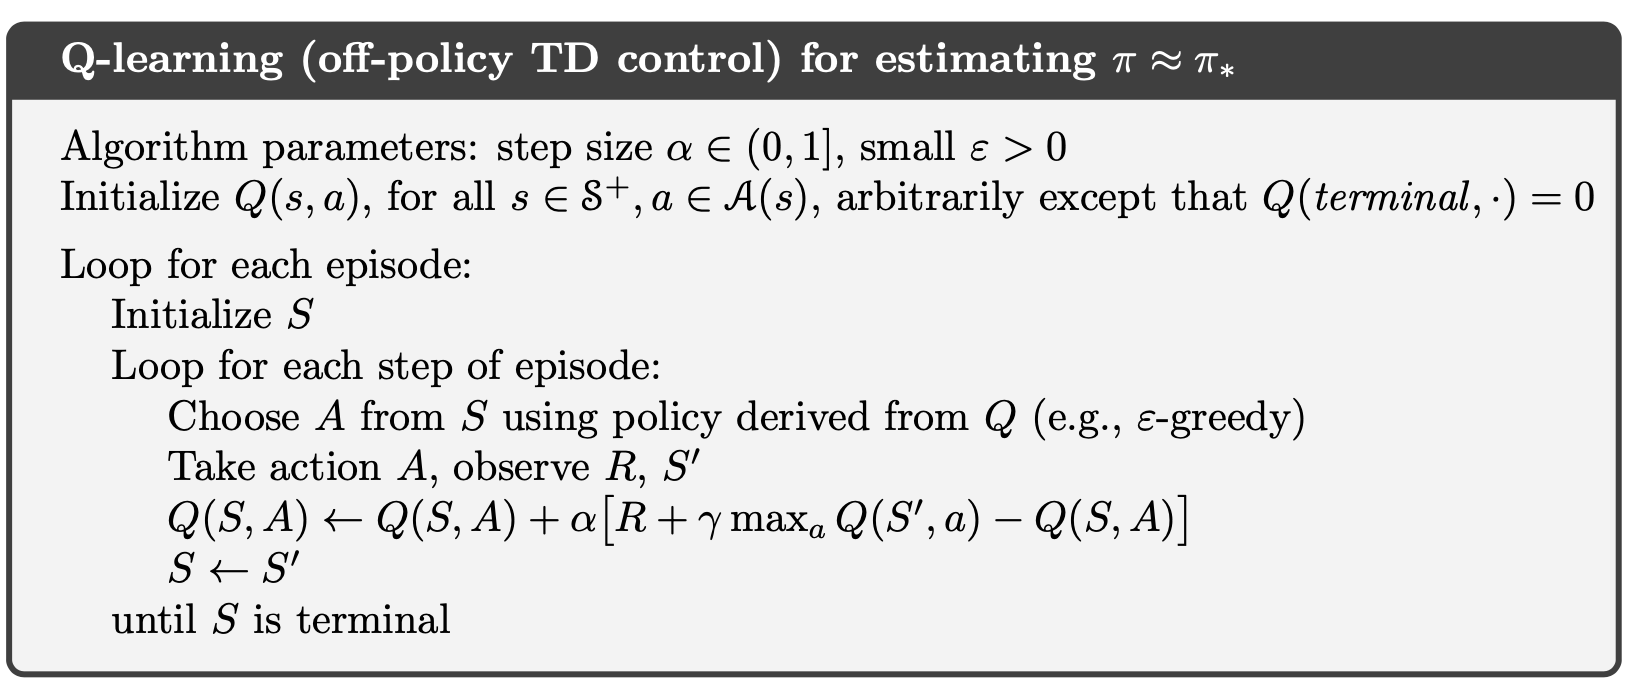

### Enviroment

In [142]:
class CWorld:
  def __init__(self, data: networkx.classes.digraph.DiGraph,start: tuple,terminal: tuple):
    self._terminal = terminal
    self._start = start
    self.data = data 

  def get_adjacent(self, node: tuple):
    # Get adjacent nodes from original node
    #return: nodes (should be tuple of coordinates)
    return self.data.neighbors(node)

  def get_reward(self, nodeStart: tuple, nodeEnd: tuple):
    #Get reward (distance, in meters between two nodes) - Haversine formula
    #return (absolute?) number
      if nodeStart == self._terminal: #Should this be nodeEnd? someone double check the logic
        return 0
      return - self.data.get_edge_data(nodeStart,nodeEnd) #reward is negative distance

In [143]:
################### To do

#Run program so it works

##### Figure out whether we should do directed graph or undirected https://networkx.org/documentation/networkx-2.4/reference/classes/index.html#which-graph-class-should-i-use
#Directed means (only one way) -- Would the agent get stuck in a one way street
#Undirected means (Edge we just went through?) is allowed back in list


##### Make it look nice and functional

### function to Print Q-table a bit more nicely than it is right now (one line)

### Build interface:

# Either let user choose what buildings they want to go from / to
# Or let the user input coordinates:
  #Iterate through every coordinate and see which one has the shortest distance to original coordinate
  # assign that coordinate 

### Build output
# Either 
  #1. I have printed a map above, and a picture of the graph
  #we could a subset of the big graph with only our optimal route and overlay it on top of the OSM maps
  ##Make sure to turn osm map's interactive flag off 
  ## will have to align it

#harder probably:
#2: use osm to map, and 
  # - create .gpx (gps routes) between the points. 
  # - Import those into geoJson or something that can be added into the original OSM map i printed

##### Bugs to look out for:
# getting stuck with directed graph: i added max number of steps to maybe guard against that
#something else but i forgot lmao


In [144]:
#Scrap:
# making a list of campus buildings from ways with the building tag
tempData = api.query('[bbox:44.2224495448,-76.5017059541,44.2298231916,-76.4903552918];(way;);out;')
buildingNames = []
wayId = []
for w in tempData.ways:
  #print(w.tags.keys())#[access'])
  if "building" in w.tags.keys():
    if "name" in w.tags.keys():
      buildingNames.append(w.tags["name"])
      wayId.append(w.id)

print(buildingNames)
#End scrap

['Douglas Library', 'Stauffer Library', 'Robert Sutherland Hall', 'Macdonald Hall', 'Richardson Hall', 'Ontario Hall', 'Ellis Hall', 'Jeffery Hall', 'Chernoff Hall', 'Watts Hall', 'Chernoff Auditorium', 'Chown Hall', 'Morris Hall', 'McLaughlin Hall', 'Watson Hall', 'Harrison-LeCaine Hall', 'Agnes Queen’s Art Gallery', 'Grant Hall', 'Nicol Hall', 'Jackson Hall', 'Old Medical Building', 'Humphrey Hall', 'Kathleen Ryan Hall', 'Louise D. Acton Building', 'Cancer Research Institute', 'Clark Hall', 'Carruthers Hall', 'Cataraqui Building', 'Abramsky Hall', 'Dupuis Hall', 'Goodwin Hall', 'Walter Light Hall', 'Stirling Hall', 'LaSalle Building', 'Theological Hall', "Central Heating Plant - Queen's University & KGH", 'Kingston Hall', 'Grey House', 'Botterell Hall', 'University Club', 'Etherington Hall', 'Richardson House', 'Kidd House', 'Physical Plant Services Shed', "Queen's School of Medicine", 'Kinesiology Building', 'The Grad Club', "St. James' Anglican Church", 'Summerhill', 'Beamish-Munro

## Interface

Choose starting points from user

In [145]:
# Please uncomment a line to Choose a starting point
#s =         #Douglas Library
#s =          # Stauffer Library
s = ((all_campus_result.get_node(805743616,True)).lat,(all_campus_result.get_node(805743616,True)).lon)         #Nixon feild

# Please uncomment a line to Choose a starting point
#t =         #Douglas Library
#t =          # Stauffer Library
#t = all_campus_result.get_node(9224895888)         #Ontario Hall
t = ((all_campus_result.get_node(9130940237,True)).lat,(all_campus_result.get_node(9130940237,True)).lon) #Ellis Hall

# Alternativly input coordinates to choose a starting point and ending point
#start_latitude = 
#start_longitude =
#s = coor_resolve_to_node(start_latitude,start_longitude) 

#end_latitude = 
#end_longitude =
#t = coor_resolve_to_node(end_latitude,end_longitude)  

def coor_resolve_to_node(latitude,longitide) -> tuple:
  # Check to do
  pass



In [146]:
def Interface(start: tuple, terminal: tuple):
  alpha = 0.1
  gamma = 0.9
  e = 0.4
  world = CWorld(G,start,terminal)

  print("Bulding the Table")
  agent = Q_learning(world, alpha=alpha, gamma=gamma, e=e)
  print(agent.q)
  
  print("Training the agent")
  agent.train()
  print("Training the agent")
  
  print("Showing Best route")
  optimal_policy = agent.optimal_policy()
  print(optimal_policy)

In [147]:
#print(s) -76.4954947, 44.2251465 -> 
#print(s[1])
Interface(s,t)
# the current problem is maybe happenimnng because the inputted coordinates are wrong.
# Soltuion: choose one of the coordinates from our graph?

Bulding the Table
{(-76.4905204, 44.2249349): {(-76.4906166, 44.2249251): 10, (-76.4904534, 44.2249392): 10, (-76.4905212, 44.2249437): 10, (-76.4905148, 44.2248758): 10}, (-76.4906166, 44.2249251): {(-76.4905204, 44.2249349): 10, (-76.4908169, 44.2249044): 10, (-76.4906304, 44.2250021): 10, (-76.4906052, 44.2248614): 10}, (-76.4908169, 44.2249044): {(-76.4906166, 44.2249251): 10, (-76.4910503, 44.2248791): 10}, (-76.4910503, 44.2248791): {(-76.4908169, 44.2249044): 10, (-76.4916043, 44.2247953): 10, (-76.4910369, 44.2248081): 10}, (-76.4916043, 44.2247953): {(-76.4910503, 44.2248791): 10, (-76.4920893, 44.2247281): 10, (-76.49161, 44.2248575): 10}, (-76.4920893, 44.2247281): {(-76.4916043, 44.2247953): 10, (-76.4925185, 44.2246686): 10, (-76.492046, 44.2246693): 10, (-76.4921255, 44.2247811): 10}, (-76.4925185, 44.2246686): {(-76.4920893, 44.2247281): 10, (-76.4933756, 44.2245498): 10}, (-76.4933756, 44.2245498): {(-76.4925185, 44.2246686): 10, (-76.4937009, 44.2245047): 10, (-76.4933

KeyError: ignored

# Everything below will help you build the interface

Using "Forms"

In [ ]:
#@title String fields

text = 'value' #@param {type:"string"}
dropdown = '1st option' #@param ["1st option", "2nd option", "3rd option"]
text_and_dropdown = 'value' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}

print(text)
print(dropdown)
print(text_and_dropdown)

In [ ]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

option2 = "A" #@param ["A", "B", "C"]
print('You selected', option2)


## Map View of route


In [ ]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

In [ ]:
#Define coordinates of where we want to center our map
campus_coords = [44.2265204, -76.4959298]

#Create the map
my_map = folium.Map(location = campus_coords, zoom_start = 16)

#Create markers
start_coords = [s.lat,s.lon]
terminal_coords = [t.lat,t.lon]
#print (start_coords)

folium.Marker(start_coords, popup = 'Start').add_to(my_map)
folium.Marker(terminal_coords, popup = 'End').add_to(my_map)

#Display the map
my_map

#Whats left to display a route
# Generate a list of way ids in our code
# (do an api call?) to get OSM data for these ways
# convert .osm to .geojson (done, using !osm) !osmtogeojson file1.osm > file2.geojson

In [ ]:
#!https://www.overpass-api.de/api/interpreter?data=[out:json];node[highway=speed_camera];out%20meta;
#!https://www.overpass-api.de/api/interpreter?data=[out:json];node[highway=speed_camera](43.46669501043081,-5.708215989569187,43.588927989569186,-5.605835010430813);out%20meta; --output-document=out.xml
!https://www.overpass-api.de/api/interpreter?data=node[highway=speed_camera](43.46669501043081,-5.708215989569187,43.588927989569186,-5.605835010430813);out&20meta;;

#!wget --post-file=query.txt http://overpass-api.de/api/interpreter --output-document=out.xml



In [ ]:
#selectedNodeIds=""
#for nodes in 
#overpass.query(node[])
#Not finished but so close -> need to figure out how to put this stupid geojson file into the foliam map and we are set
!cp /content/cache/api-f6f7201ed9c847b8c895891416142873af55d69f /content/api1.osm
#!osmtogeojson /content/api1.osm > /content/way.geojson
geojsonFeature = "/content/way.geojson"
#print(geojsonFeature)
#folium.GeoJson(geojsonFeature).addTo(my_map);